# Halo Occupation Distribution from extragalactic catalogs

> Notebook owner: Yao-Yuan Mao [@yymao](https://github.com/LSSTDESC/DC2-analysis/issues/new?body=@yymao). Last run: Mar 8, 2024 by @patricialarsen

In this notebook we demostrate how to plot the halo occupation distribution of the cosmoDC2/skysim/roman_rubin galaxy catalogs.

## Learning objectives
- Use `GCRCatalogs` to access the cosmoDC2, skysim or roman_rubin catalogs. 
- Access cosmology in the extragalactic catalogs.
- Use `CCL` to predict Halo Mass Function.

In [1]:
import GCRCatalogs

In [2]:
import pyccl as ccl

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Catalog selection
Uncomment the line corresponding to the catalog you want to inspect

In [4]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
#gc = GCRCatalogs.load_catalog('skysim5000_v1.1.2_small')
#gc = GCRCatalogs.load_catalog('roman_rubin_2023_v1.1.3_elais')


In [5]:
zmax = 0.25
mass_bins = np.logspace(10, 15, 21)
mass_center = np.sqrt(mass_bins[1:] * mass_bins[:-1])

### Get the data
Retrieve the data given the maximum redshift value determined above


In [20]:
data = gc.get_quantities(['halo_mass', 'Mag_true_r_lsst_z0', 'redshift','halo_id'], filters=['redshift < {}'.format(zmax)])

### Cosmology
Retrieve the cosmological parameters and use them to create a ccl cosmology object

In [7]:
cosmo = ccl.Cosmology(
    Omega_c=gc.cosmology.Om0-gc.cosmology.Ob0, 
    Omega_b=gc.cosmology.Ob0, 
    h=gc.cosmology.h, 
    sigma8=gc.cosmology.sigma8, 
    n_s=gc.cosmology.n_s, 
    transfer_function='bbks',
)

### Get expected halo mass function from CCL
We approximate the hmf by using the mean redshift, create a mass definition and decide which mass function to use

In [12]:
# approximate hmf using mean redshift
mean_scale_factor = 1.0/(1.0+data['redshift'].mean())

hmd_fof = ccl.halos.MassDefFof
mf = ccl.halos.MassFuncSheth99(mass_def=hmd_fof)
hmf_dn_dlogm =  mf(cosmo, mass_center, mean_scale_factor)


### Determine expected number of halos

Use the halo mass function and the volume (given by 4/3 pi * fsky * r^3) to get the total number of halos expected in the volume. We also select on halo ids to get the true number of halos in the volume. 

In [31]:
d = gc.cosmology.comoving_distance(zmax).to('Mpc').value
volume = np.deg2rad(np.deg2rad(gc.sky_area)) * d**3 / 3.0

In [32]:
dlogm = np.ediff1d(np.log10(mass_bins))
nhalo_expected = hmf_dn_dlogm * volume * dlogm

hid,idx,count=np.unique(data['halo_id'],return_index=True,return_counts=True)

### Plot halo occupation distribution

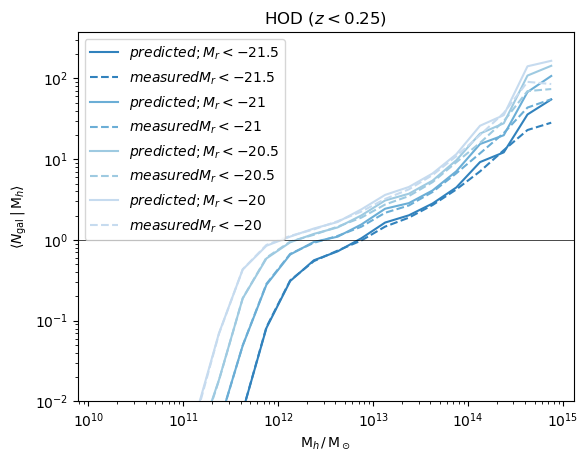

In [34]:
for Mr_thres, color in zip((-21.5, -21, -20.5, -20), plt.cm.tab20c.colors):
    plt.loglog(
        mass_center, 
        np.histogram(data['halo_mass'][data['Mag_true_r_lsst_z0'] < Mr_thres], mass_bins)[0] / nhalo_expected,
        label=r'$M_r < {}$'.format(Mr_thres),
        c=color,
    );
    plt.loglog(
        mass_center, 
        np.histogram(data['halo_mass'][data['Mag_true_r_lsst_z0'] < Mr_thres], mass_bins)[0]/np.histogram(data['halo_mass'][idx], mass_bins)[0],
        label=r'$measured M_r < {}$'.format(Mr_thres),
        c=color,
        linestyle='--'
    );


plt.xlabel(r'${\rm M}_h \,/\, {\rm M}_\odot$');
plt.ylabel(r'$\langle N_{\rm gal} \,|\, {\rm M}_h \rangle$');
plt.title(r'HOD $(z < 0.25)$');
plt.ylim(0.01, None)
plt.axhline(1, lw=0.5, c='k');
plt.legend();

In [19]:
np.histogram(data['halo_mass'][data['Mag_true_r_lsst_z0'] < Mr_thres], mass_bins)[0]

array([   0,    0,    1,   82,  209, 1364, 5001, 5852, 4497, 3333, 2338,
       1929, 1648, 1139,  893,  784,  837,  486,  727,  256])

In [26]:
hid,idx,count=np.unique(data['halo_id'],return_index=True,return_counts=True)

np.histogram(data['halo_mass'][data['Mag_true_r_lsst_z0'] < Mr_thres], mass_bins)[0]/np.histogram(data['halo_mass'][idx], mass_bins)[0]

array([0.00000000e+00, 0.00000000e+00, 1.27534753e-05, 1.09870969e-03,
       5.88699228e-03, 6.90143696e-02, 4.31977196e-01, 8.67219917e-01,
       1.12060802e+00, 1.35267857e+00, 1.70532458e+00, 2.24563446e+00,
       3.21875000e+00, 4.23420074e+00, 6.37857143e+00, 1.08888889e+01,
       1.99285714e+01, 3.73846154e+01, 9.08750000e+01, 8.53333333e+01])